Example to run RTTOV given NWP data at satellite location

In [1]:
import sys
# The pyrttov package and the RTTOV rttov_wrapper_f2py.so library must be in your $PYTHONPATH
# Add location of pyrttov and rttov_wrapper_f2py.so to the python path
# WARNING: set RTTOV version (rttovVer) in mw_rttov_cfg.py 
sys.path.append('/home/fab/rttov130/wrapper')

import os
import xarray as xr
from datetime import datetime
from rttov13v0_interface import run_rttov

/home/fab/anaconda3/envs/mw_rttov/lib/python3.9/site-packages/ecmwflibs/__init__.py:69: UserWarning: ecmwflibs: ignoring provided 'ECCODES_DEFINITION_PATH' set to '/usr/share/eccodes/definitions'. If you want ecmwflibs to use this environment variable, use ECMWFLIBS_ECCODES_DEFINITION_PATH instead. If you want to use your own ECCODES library, use ECMWFLIBS_ECCODES.
  warnings.warn(


In [2]:
# WARNING: mw_rttov_cfg.py contains 
# - some variables which can be used to tune RTTOV  
# - the logic to handle the satellite sensor according to the variable strSatId (e.g. channels to be simulated, satZenAngle, rttov files to get, constant ice emis)

# String to identify the satellite to simulate.
# The following strings are implemented in mw_rttov_cfg.py: amsr2, ssmis_f16 ssmis_f17, ssmis_f18
# To add any other satellite add a string and the necessary logic in mw_rttov_cfg.py 
# WARNING: in this implemenatation we consider a constant satZenAngle which is defined in the mw_rttov_cfg.py according to the sensor
strSatId = 'amsr2'

topPath    = '/home/fab/Desktop/ieee_rtm_corr_sic/nwp_swath_era5/20190225'
swath_time = '201902250529'

# Collocated NWP surface variables
ncSurfNwp2swath = os.path.join(topPath,swath_time, 'surf.era5TOamsr2.'+swath_time+'.nc')
# Collocated NWP model level variables
ncProfNwp2swath = os.path.join(topPath,swath_time, 'ml.era5TOamsr2.'+swath_time+'.nc')

# Expected RTTOV path which are in your RTTOV package. Within this paths we expect necessary input files to run RTTTOV  
# Mandatory: where to find rttov coef files for the mw sensor which must be simulated (e.g. rtcoef_gcom-w_1_amsr2.dat)
rttovCoefDir = '/home/fab/rttov132/rtcoef_rttov13/rttov13pred54L'
# Mandatory when rttovScatt = True: where to find hydrotable file for the mw sensor which must be simulated (e.g. hydrotable_gcom-w_amsr2.dat)
rttovHydDir  = '/home/fab/rttov132/rtcoef_rttov13/hydrotable'
# Mandatory when useEmisAtlas = True: where to find expected MW emissvity atlas files (hdf5) 
rttovAtlasEmisDir = '/home/fab/rttov132/emis_data'

# False: simulate atmospheric absorption (T, Q, CLWC are only used as NWP profile) 
# True: use RTTOV-SCATT to active the calculation of scattering (CIWC, CRWC, CSWC and CC are also mandatory as NWP profiles)
rttovScatt = False

# Emis is computed as Emis = (1-sic)*EmisOcean + sic*EmisIce, where
# EmisOcean is extracted from RTTOV (e.g. FATSEM emis) 
# EmisIce is:  
#    useEmisAtlas = False: use a constant values (defined in mw_rttov_cfg.py) or (to be implemented) any other estimate/model     
#    useEmisAtlas = True: use TELSEM MW emissvity atlas
useEmisAtlas = False

# active calculation of BT with 'no Atmosphere' (necessary for SIC algorithm)
# if True simTb_noAtm is populated, otherwise return empty list
calbBTnoAtm = True

In [3]:
# Collocated NWP surface variables
surfNwp2swath = xr.open_dataset(ncSurfNwp2swath)
# Collocated NWP model level variables
profNwp2swath = xr.open_dataset(ncProfNwp2swath)

# Surface
lats = surfNwp2swath['lat'].data
lons = surfNwp2swath['lon'].data
sic  = surfNwp2swath['sic'].data
skt  = surfNwp2swath['skt'].data
t2m  = surfNwp2swath['t2m'].data
u10  = surfNwp2swath['u10'].data
v10  = surfNwp2swath['v10'].data
sp   = surfNwp2swath['sp'].data

# sic must be [0-1]
if sic.max() > 1:
    sic = sic/100.

# Model Level
profT = profNwp2swath['t'].data
profQ = profNwp2swath['q'].data
profCLWC = profNwp2swath['clwc'].data
profCIWC = profNwp2swath['ciwc'].data
profCRWC = profNwp2swath['crwc'].data
profCSWC = profNwp2swath['cswc'].data
profCC   = profNwp2swath['cc'].data
hPaFullLevels = profNwp2swath['pf'].data
hPaHalfLevels = profNwp2swath['ph'].data

In [25]:
'sp {0}'.format(sp[0])

'sp 97653.59375'

In [26]:
'profQ {0}'.format(profQ[0,:])

'profQ [2.3075172e-06 4.0337582e-06 4.0840214e-06 4.0779360e-06 3.9467436e-06\n 3.7573839e-06 3.4976622e-06 3.3258700e-06 3.1948439e-06 3.0906526e-06\n 2.9465177e-06 2.8153195e-06 2.7404744e-06 2.7185902e-06 2.6691221e-06\n 2.5962788e-06 2.5623879e-06 2.5018962e-06 2.9503301e-06 3.2536361e-06\n 9.4510024e-06 1.4501780e-05 3.5029207e-05 4.8714130e-05 9.5835057e-05\n 2.8156661e-04 9.8361052e-04 1.6164107e-03 1.8984259e-03 2.4554334e-03\n 3.0153531e-03 3.2861801e-03 3.4601693e-03 3.4873991e-03 3.5071415e-03]'

In [27]:
'profCC {0}'.format(profCC[0,:])

'profCC [0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.01406234 0.743435   0.89538085 0.46525884\n 0.98120046 0.868566   0.00123207 0.         0.        ]'

In [28]:
'profCLWC {0}'.format(profCLWC[0,:])

'profCLWC [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00\n 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00\n 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00\n 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00\n 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00\n 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00\n 0.00000000e+00 0.00000000e+00 1.37674778e-08 1.04359526e-04\n 7.40015093e-05 4.54444807e-06 2.26140819e-05 2.24817468e-05\n 0.00000000e+00 0.00000000e+00 0.00000000e+00]'

In [29]:
 'hpa full {0}'.format(hPaFullLevels[0,:])

'hpa full [1.00018252e-02 8.28747153e-02 2.89857149e-01 7.82082319e-01\n 1.75308979e+00 3.42701554e+00 6.03876686e+00 9.81772995e+00\n 1.49769650e+01 2.17076378e+01 3.01775532e+01 4.05321045e+01\n 5.28644295e+01 6.71940842e+01 8.38800583e+01 1.03693436e+02\n 1.27259697e+02 1.55043854e+02 1.87540024e+02 2.25289185e+02\n 2.68882812e+02 3.18959045e+02 3.76196411e+02 4.41306580e+02\n 5.14881409e+02 5.94062622e+02 6.72634460e+02 7.45000916e+02\n 8.07322205e+02 8.58029480e+02 8.97452209e+02 9.27053162e+02\n 9.48718567e+02 9.64297363e+02 9.75378845e+02]'

In [30]:
 'hpa half {0}'.format(hPaHalfLevels[0,:])

'hpa half [0.0000000e+00 2.0003650e-02 9.7469665e-02 3.2985711e-01 8.6895883e-01\n 1.9133856e+00 3.6898236e+00 6.4333992e+00 1.0372012e+01 1.5716229e+01\n 2.2654316e+01 3.1351194e+01 4.1949306e+01 5.4529907e+01 6.9118706e+01\n 8.6142792e+01 1.0639470e+02 1.3045882e+02 1.5880031e+02 1.9191820e+02\n 2.3035988e+02 2.7472299e+02 3.2565115e+02 3.8382755e+02 4.4996744e+02\n 5.2456653e+02 6.0405353e+02 6.8217407e+02 7.5347693e+02 8.1439685e+02\n 8.6363989e+02 9.0172760e+02 9.3021570e+02 9.5100885e+02 9.6593317e+02\n 9.7653595e+02]'

NWP surface & model level variables are collocated on the satellite swath (pyresample is used).
For every observation location (lat/lon), we have the corresponding model value. NWP AN/FC date/time is simply the closest to the central time of the satellite scan.

NWP inputs to function 'run_rttov'

Surface

 lats (1D, dim=nobs): latitude of observation location
 
 lons (1D, dim=nobs): langitude of observation location
 
 sic (1D, dim=nobs): sea ice cocnetration [0-1]
 
 tsk (1D, dim=nobs): skin temperature [K]
 
 t2m (1D, dim=nobs): 2m temperature [K]
 
 u10 (1D, dim=nobs): 10m wind u-component [m s-1]
 
 v10 (1D, dim=nobs): 10m wind v-component [m s-1]
 
 surfPre (1D, dim=nobs): surface pressure [Pa]
 

Model level ('Profile')

 profT (2D, dim=(nobs,nlevFull)): temperature [K] on model level
 
 profQ (2D, dim=(nobs,nlevFull)): specific humidity [kg kg-1] on model level
 
 profCLWC (2D, dim=(nobs,nlevFull)): cloud liquid water content [kg kg-1] on model level
 
 profCIWC (2D, dim=(nobs,nlevFull)): cloud ice water content [kg kg-1] on model level
 
 profCRWC (2D, dim=(nobs,nlevFull)): specific rain water content [kg kg-1] on model level
 
 profCSWC (2D, dim=(nobs,nlevFull)): specific snow water content [kg kg-1] on model level
 
 profCC (2D, dim=(nobs,nlevFull)): fraction of Cloud Cover [0-1] on model level
 
 hPaFullLevels (2D, dim=(nobs,nlevFull)): full model level [hPa]
 
 hPaHalfLevels(2D, dim=(nobs,nlevHalf)): half model level [hPa]

When RTTOV-SCATT is used (rttovScatt=True) the following variables are mandatory: hPaHalfLevels, profCIWC, profCRWC, profCSWC, profCC
 

Outputs of function 'run_rttov'

For each selected sensor's channel:
    
simTb:       simulated brightness temperatures

simTb_noAtm: simulated brightness temperatures 'no Atm' 

surfEmis:    surface emissivty used in the radiative transfer calculations [E = (1-sic)*Eocean + sic*Eice]

strChsList:  list of channels (string that identifies GHz + pol)

RTM for 'no atm': u10=0, v10=0, profQ=0, profCLWC=0, profCIWC=0, profCRWC=0, profCSWC=0, profCC=0

In [3]:
# Collocated NWP surface variables
surfNwp2swath = xr.open_dataset(ncSurfNwp2swath)
# Collocated NWP model level variables
profNwp2swath = xr.open_dataset(ncProfNwp2swath)

# Surface
lats = surfNwp2swath['lat'].data
lons = surfNwp2swath['lon'].data
sic  = surfNwp2swath['sic'].data
skt  = surfNwp2swath['skt'].data
t2m  = surfNwp2swath['t2m'].data
u10  = surfNwp2swath['u10'].data
v10  = surfNwp2swath['v10'].data
sp   = surfNwp2swath['sp'].data

# sic must be [0-1]
if sic.max() > 1:
    sic = sic/100.

# Model Level
profT = profNwp2swath['t'].data
profQ = profNwp2swath['q'].data
profCLWC = profNwp2swath['clwc'].data
profCIWC = profNwp2swath['ciwc'].data
profCRWC = profNwp2swath['crwc'].data
profCSWC = profNwp2swath['cswc'].data
profCC   = profNwp2swath['cc'].data
hPaFullLevels = profNwp2swath['pf'].data
hPaHalfLevels = profNwp2swath['ph'].data

strYYYYMMDDHHMMs = surfNwp2swath.sensor_scan_start_time
strYYYYMMDDHHMMe = surfNwp2swath.sensor_scan_end_time

scanStartTime = datetime.strptime(strYYYYMMDDHHMMs, '%Y%d%m%H%M')
scanEndTime   = datetime.strptime(strYYYYMMDDHHMMe, '%Y%d%m%H%M')
centralSwathTime = scanStartTime + (scanEndTime - scanStartTime)/2 

# if available, provide satZenAngle at every obs location (1D, dim=nobs)
# otherwise, satZenAngle = [0] and a constant value will be used according to the satellite sensor
satZenAngle = [0]

# Init lists (this is to have the possibility of comparing different simulations)
tbList      = []
tbNoatmList = []
emisList    = []

##################################################
# Sim 1: rttovScatt = True & useEmisAtlas = False
##################################################
rttovScatt = False
useEmisAtlas = False

simTb, simTb_noAtm, surfEmis, strChsList, emis_param_dict = run_rttov(lats,
                                                                      lons,
                                                                      sic,
                                                                      skt,
                                                                      t2m,
                                                                      u10,
                                                                      v10,
                                                                      sp,
                                                                      profT,
                                                                      profQ,
                                                                      profCLWC,
                                                                      profCIWC,
                                                                      profCRWC,
                                                                      profCSWC,
                                                                      profCC,
                                                                      hPaFullLevels,
                                                                      hPaHalfLevels,
                                                                      strSatId,
                                                                      satZenAngle,
                                                                      centralSwathTime,
                                                                      rttovCoefDir,
                                                                      rttovHydDir,
                                                                      rttovAtlasEmisDir,
                                                                      rttovScatt,
                                                                      useEmisAtlas,
                                                                      calbBTnoAtm) 

# Append data to list (this is to have the possibility of comparing different simulations)
tbList.append(simTb)
tbNoatmList.append(simTb_noAtm)
emisList.append(surfEmis)

##################################################
# Sim 2: rttovScatt = True & useEmisAtlas = True
##################################################
rttovScatt = True
useEmisAtlas = False

simTb, simTb_noAtm, surfEmis, strChsList, emis_param_dict = run_rttov(lats,
                                                                      lons,
                                                                      sic,
                                                                      skt,
                                                                      t2m,
                                                                      u10,
                                                                      v10,
                                                                      sp,
                                                                      profT,
                                                                      profQ,
                                                                      profCLWC,
                                                                      profCIWC,
                                                                      profCRWC,
                                                                      profCSWC,
                                                                      profCC,
                                                                      hPaFullLevels,
                                                                      hPaHalfLevels,
                                                                      strSatId,
                                                                      satZenAngle,
                                                                      centralSwathTime,
                                                                      rttovCoefDir,
                                                                      rttovHydDir,
                                                                      rttovAtlasEmisDir,
                                                                      rttovScatt,
                                                                      useEmisAtlas,
                                                                      calbBTnoAtm) 

# Append data to list (this is to have the possibility of comparing different simulations)
tbList.append(simTb)
tbNoatmList.append(simTb_noAtm)
emisList.append(surfEmis)

[INFO: 2023-12-19 02:16:04: rttov13v0_interface] RTTOV VERSION from mw_rttov_cfg.py is v13.0
[INFO: 2023-12-19 02:16:04: rttov13v0_interface] Constant sat zenith angle of 55.0 is used at every obs location
[INFO: 2023-12-19 02:16:04: rttov13v0_interface] Calculating surface emissvity for RTTOV
[INFO: 2023-12-19 02:16:05: calc_emis_for_rttov] MW sensor: amsr2
[INFO: 2023-12-19 02:16:05: calc_emis_for_rttov] Rttov coef file: /home/fab/rttov132/rtcoef_rttov13/rttov13pred54L/rtcoef_gcom-w_1_amsr2.dat
[INFO: 2023-12-19 02:16:05: calc_emis_for_rttov] Number of channels selected for RTTOV: 12
[INFO: 2023-12-19 02:16:05: calc_emis_for_rttov] - List of selected channels: [1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14]
[INFO: 2023-12-19 02:16:05: calc_emis_for_rttov] - Freq (GHz): [ 6.925       6.925       7.3         7.3        10.65       10.65
 18.7        18.7        36.49999999 36.49999999 88.99999999 88.99999999]
[INFO: 2023-12-19 02:16:05: calc_emis_for_rttov] ***********************************

[INFO: 2023-12-19 02:17:02: rttov13v0_calc_bt] Rttov coef file: /home/fab/rttov132/rtcoef_rttov13/rttov13pred54L/rtcoef_gcom-w_1_amsr2.dat
[INFO: 2023-12-19 02:17:02: rttov13v0_calc_bt] Number of channels selected for RTTOV: 12
[INFO: 2023-12-19 02:17:02: rttov13v0_calc_bt] - List of selected channels: [1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14]
[INFO: 2023-12-19 02:17:02: rttov13v0_calc_bt] - Freq (GHz): [ 6.925       6.925       7.3         7.3        10.65       10.65
 18.7        18.7        36.49999999 36.49999999 88.99999999 88.99999999]
[INFO: 2023-12-19 02:17:02: rttov13v0_calc_bt] ****************************************************************
[INFO: 2023-12-19 02:17:02: rttov13v0_calc_bt] RTTOV runDirect started (compute BT for 'no atm')
[INFO: 2023-12-19 02:17:02: rttov13v0_calc_bt] Tot number of profiles: 127171
[INFO: 2023-12-19 02:17:02: rttov13v0_calc_bt] Tot number of threads: 4
[INFO: 2023-12-19 02:17:02: rttov13v0_calc_bt] Do Lambertian: True
[INFO: 2023-12-19 02:17:10:

In [4]:
####################################
# Preapre data for diagnostic plots
####################################
from diagnostic_plots import diag_simBT, diag_departures, diag_corrBT, diag_atmCorr

# Get observations for the swath file we simulated
strYYYYMMDDHHMM = swath_time
ncObsBt = os.path.join(topPath,swath_time, 'obsBT.amsr2.'+swath_time+'.nc')
obsBT = xr.open_dataset(ncObsBt)

# Num of simulations
nSim  = len(tbList)

# String to identfy every simulation in tbList
expLabelList = ['rt','rt-scatt']

# now get data for 36.5 Ghz V
strCh = '18.7V'

ich = strChsList.index(strCh)
obsCh = obsBT[strCh].data
    
simChList   = []
atmCorrList = []
emisChList  = []

for nS in range(0,nSim):
    simChList.append(tbList[nS][:,ich])
    atmCorrList.append(tbNoatmList[nS][:,ich]-tbList[nS][:,ich])
    emisChList.append(emisList[nS][:,ich])
        

diagnostic plots Obs Vs Sim for channel 18.7V


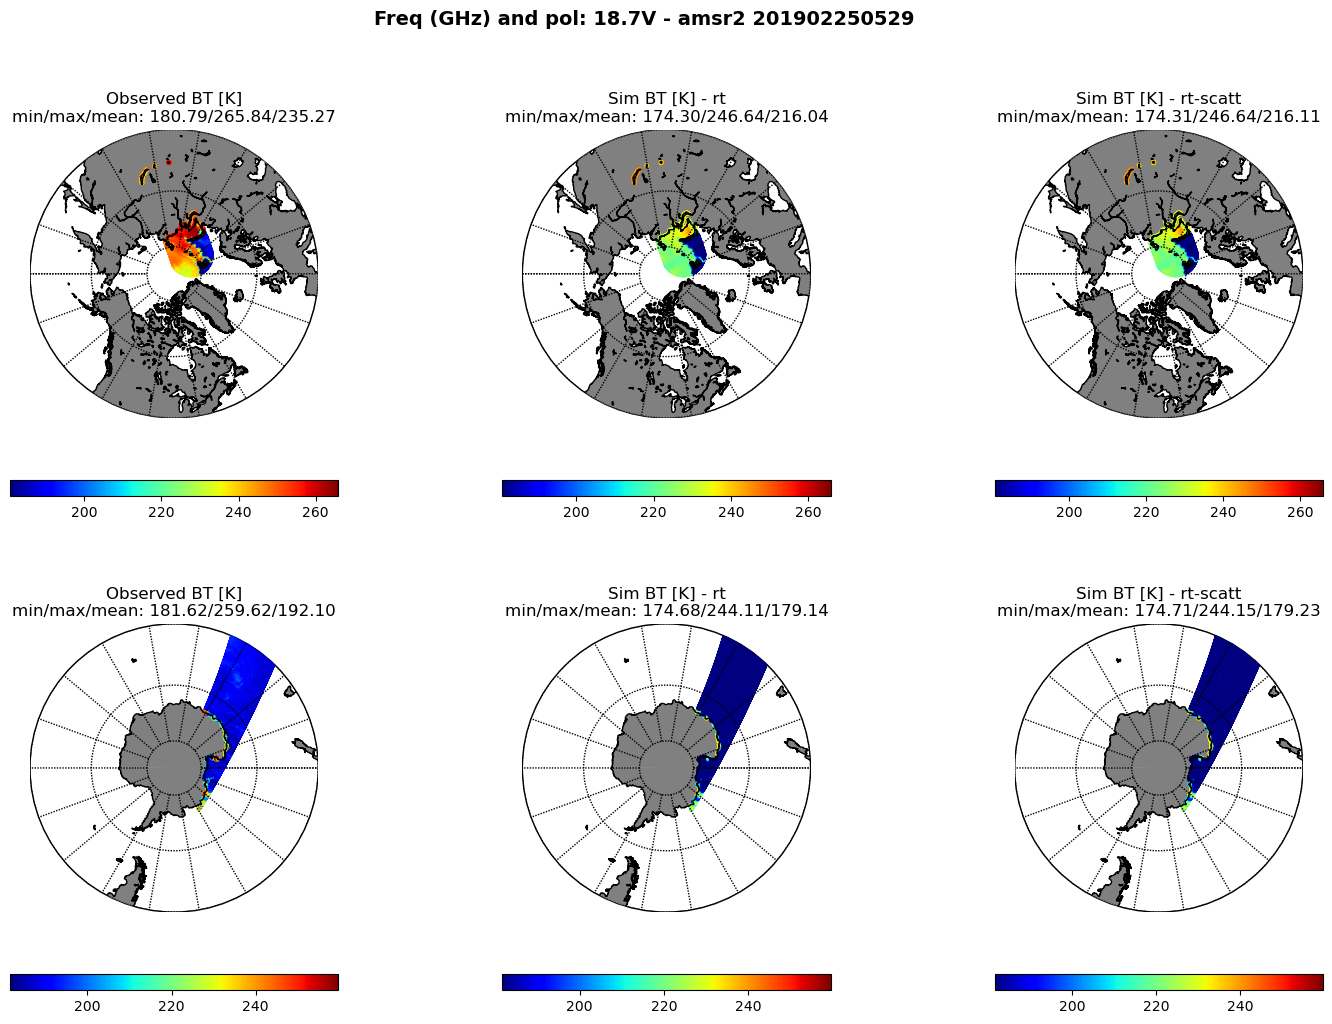

In [5]:
print ('diagnostic plots Obs Vs Sim for channel {}'.format(strCh))
diag_simBT(lats,lons, obsCh, simChList, strCh, strSatId, expLabelList, strYYYYMMDDHHMM)

diagnostic plots Departures for channel 18.7V


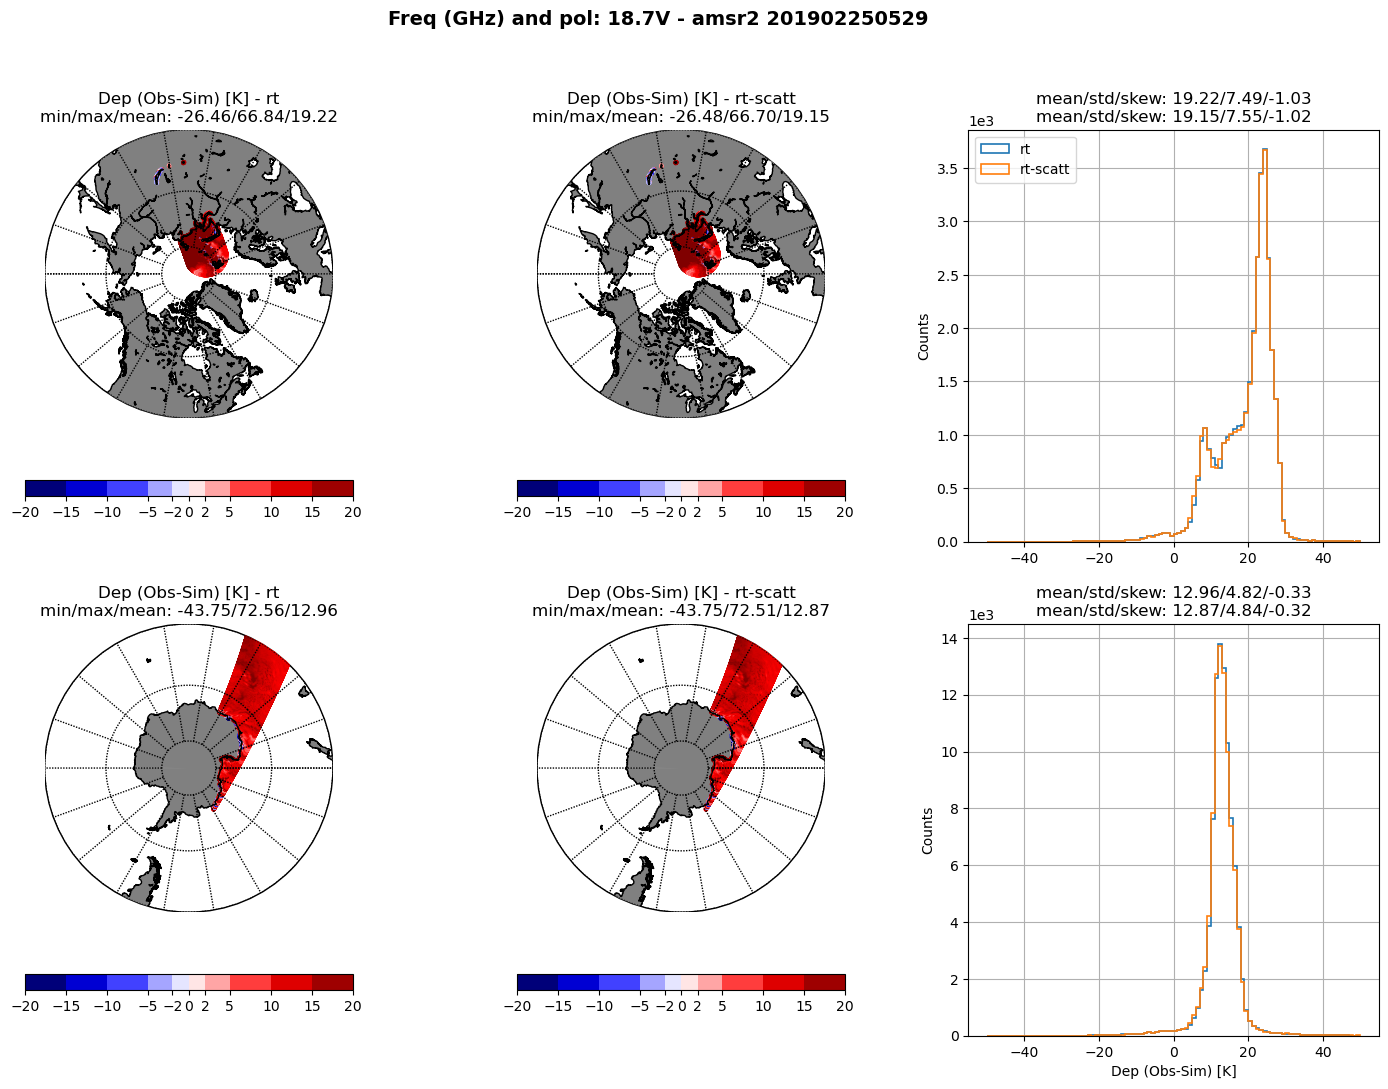

In [6]:
print ('diagnostic plots Departures for channel {}'.format(strCh))
diag_departures(lats, lons, obsCh, simChList, strCh, strSatId, expLabelList, strYYYYMMDDHHMM)

In [ ]:
print ('diagnostic plots Corrected BT for channel {}'.format(strCh))
diag_corrBT(lats,lons, obsCh, atmCorrList, strCh, strSatId, expLabelList, strYYYYMMDDHHMM)

In [ ]:
print ('diagnostic plots Atm Corr for channel {}'.format(strCh))
diag_atmCorr(lats,lons, obsCh, atmCorrList, strCh, strSatId, expLabelList, strYYYYMMDDHHMM)